In [ ]:
!pip3 install veda-bm==0.0.1a14
!pip3 install matplotlib

In [5]:
from veda_bm import BlackMarbleRunner
from veda_bm import OperationalCredentials
from veda_bm import DestinationStorageCredentials
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [20]:
# AWS Credentials to launch ECS Jobs
access_key = ''
secret_key = ''

# Fetch a token from https://urs.earthdata.nasa.gov/
earth_data_token = '' 

In [7]:
lat1,long1,lat2,long2 = 33.034682, 21.279194, 32.465949, 22.919832
year,month,day = 2023, 1, 24

upload_bucket = 'veda-data-store-staging'
bucket_prefix = 'hd-blackmarble-nightlights-temp/' # This is a temp location for testing purposes

aws_region = os.environ['AWS_REGION']
aws_role_arn = os.environ['AWS_ROLE_ARN']
aws_sts_regional_endpoints = os.environ['AWS_STS_REGIONAL_ENDPOINTS']
with open(os.environ['AWS_WEB_IDENTITY_TOKEN_FILE']) as f:
    aws_id_token = f.read()

In [8]:
operational_credentials = OperationalCredentials(access_key = access_key, 
                                                 secret_key = secret_key,
                                                 earth_data_token = earth_data_token)
                                                 
upload_credentials = DestinationStorageCredentials(aws_region = aws_region, 
                                                        aws_role_arn = aws_role_arn, 
                                                        aws_id_token = aws_id_token,
                                                        aws_sts_regional_endpoints = aws_sts_regional_endpoints) 

bm_runner = BlackMarbleRunner(operational_credentials, upload_credentials)

In [9]:
# Generate the file name 

upload_file = bm_runner.get_upload_file_name(lat1 = lat1, lat2 = lat2, 
                                           long1 = long1, long2 = long2, 
                                           year = year, month = month, day = day,
                                           prefix = bucket_prefix)

In [10]:
print("Upload file name is ", upload_file)

Upload file name is  hd-blackmarble-nightlights-temp/hdnightlights_2023-01-24_34N21E32N23E-day.tif


In [11]:
# Submit the hd image generation job to AWS ECS

task_arn = bm_runner.run_bm_task(lat1 = lat1, lat2 = lat2, long1 = long1, long2 = long2, 
                                 year = year, month = month, day = day, 
                                 upload_bucket = upload_bucket,
                                 upload_file = upload_file)

print('Submitted HD Image generation to task ', task_arn)

Submitted HD Image generation to task  arn:aws:ecs:us-west-2:018923174646:task/BMWorkloadCluster/cd9d38940f5241ecb3c3468e71a0dbca


In [21]:
# Wait until the container status is 'STOPPED:ExitCode=0'

bm_runner.get_bm_task_status(task_arn)

'RUNNING'

In [8]:
# stop_bm_task(task_arn)

In [25]:
# Download file for visualication purposes

bm_runner.download_file(source_bucket = upload_bucket, 
                        source_path= upload_file, 
                        destination_path = 'img.tif')


/Users/dwannipurage3/code/veda/veda-black-marble/sdk/veda-bm/venv/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93317328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


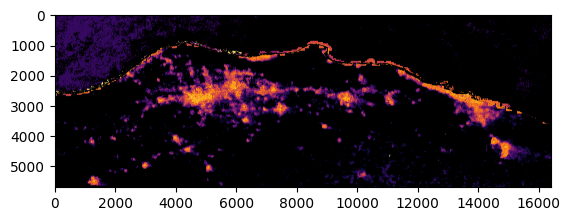

In [12]:
# Visualize the image

img = mpimg.imread('img.tif')
imgplot = plt.imshow(img)
plt.show()

In [7]:

# Copying the file from temp location to final upload directory if the output is satisfactory

new_upload_file = bm_runner.get_upload_file_name(lat1 = lat1, lat2 = lat2, 
                                           long1 = long1, long2 = long2, 
                                           year = year, month = month, day = day,
                                           prefix = 'hd-blackmarble-nightlights/')

bm_runner.copy_file(upload_bucket, upload_file, upload_bucket, new_upload_file)